In [1]:
### REMOVE LATER ###
# Go up one directory since notebook inside task3/ folder.
import os

try:
    if UP_DIR:
        print("skipping")
except NameError:
    os.chdir("..")
    UP_DIR = True

# JH's Task 3 Experiment 2
(NOTE: keep this H1 header block or add it later to denote the boundaries between notebooks when we combined later)

Attempting Hyperparameter Sweep using Optuna.

## Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from copy import deepcopy
from task3.exp2 import Hparams, tfidf_to_np, train, inference
from dataclasses import asdict
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import json
import os
import pickle

## Hyperparameters

In [3]:
TRAIN_CSV = "./data/train.csv"
TRAIN_TFIDF_CSV = "./data/train_tfidf_features_custom.csv"
TEST_CSV = "./data/test.csv"
TEST_TFIDF_CSV = "./data/test_tfidf_features_custom.csv"
HP = Hparams()

HP.val_split = 0.4

# Setup logging
EXPERIMENT_NAME = f"optuna_exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
LOG_DIR = f"./logs/{EXPERIMENT_NAME}"
os.makedirs(LOG_DIR, exist_ok=True)

TRIAL_LOG_FILE = os.path.join(LOG_DIR, "trial_results.jsonl")

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Logs will be saved to: {LOG_DIR}")

Experiment: optuna_exp_20250810_231224
Logs will be saved to: ./logs/optuna_exp_20250810_231224


## Data Engineering
Instead of using the tfidf features given in the comp, we can engineer our own tfidf features with better filtering logic, or using something other than tfidf altogether to arrive at vector representations, or perhaps even use a strategy that use non-vector representations.

### Load Data

In [4]:
# train_df = pd.read_csv(TRAIN_CSV, index_col="id")
train_tfidf_df = pd.read_csv(TRAIN_TFIDF_CSV, index_col="id")
# test_df = pd.read_csv(TEST_CSV, index_col="id")
test_tfidf_df = pd.read_csv(TEST_TFIDF_CSV, index_col="id")

In [5]:
test_X, test_y = tfidf_to_np(test_tfidf_df)
train_X, train_y = tfidf_to_np(train_tfidf_df)
train_X, val_X, train_y, val_y = train_test_split(
    train_X,
    train_y,
    test_size=HP.val_split,
    random_state=HP.seed,
    stratify=train_y,
)

print("Dataset splits:")
print("  train:", len(train_X))
print("  val:  ", len(val_X))
print("  test: ", len(test_X))

Dataset splits:
  train: 10310
  val:   6874
  test:  4296


## Optuna Hyperparameter Optimization
Setting up hyperparameter search using Optuna to find optimal parameters for our XGBoost + PCA pipeline.

In [6]:
def log_trial_result(trial_number, params, results, hp, timestamp):
    """Log trial results to JSONL."""
    
    # Prepare data for logging
    log_entry = {
        "trial_number": trial_number,
        "timestamp": timestamp,
        "val_f1": results.get("val_f1"),
        "train_f1": results.get("train_f1"),
        "f1_discrepancy": results.get("f1_discrepancy"),
        "val_err": results.get("val_err"),
        "train_err": results.get("train_err"),
        "err_discrepancy": results.get("err_discrepancy"),
        "hyperparameters": {
            # Optuna suggested parameters
            **params,
            # All hyperparameters from HP object
            "val_split": hp.val_split,
            "seed": hp.seed,
            "num_rounds": hp.num_rounds,
            "early_stopping_rounds": hp.early_stopping_rounds,
            "dim_reduction_method": hp.dim_reduction_method,
            "xgb_num_parallel_tree": hp.xgb_num_parallel_tree,
        }
    }
    
    # Log to JSONL file (one JSON object per line)
    with open(TRIAL_LOG_FILE, "a") as f:
        f.write(json.dumps(log_entry) + "\n")

In [7]:
def objective(trial: optuna.Trial):
    """Objective function for Optuna optimization."""
    
    trial_start_time = datetime.now()

    # Create a copy of base hyperparameters
    hp = deepcopy(HP)
    hp.num_rounds = 100000
    # hp.num_rounds = 1
    hp.early_stopping_rounds = 500

    # Go back to use gradient boosted trees
    hp.xgb_num_parallel_tree = 1
    # hp.xgb_num_parallel_tree = trial.suggest_int(
    #     "xgb_num_parallel_tree", 10, 200, step=10
    # )

    """ From previous experiment:
    Parameters:
        xgb_max_depth: 12
        xgb_learning_rate: 0.0020001869132760825
        xgb_subsample: 0.45260442438907245
        xgb_colsample_bynode: 0.3421942471972495
        xgb_min_child_weight: 10.60087486325813
        xgb_min_split_loss: 2.056364343369845
        xgb_lambda: 5.950284635850967
        xgb_alpha: 10.285767928640595
    """

    # Tuning to reduce overfitting
    hp.dim_reduction_method = "svd"
    # Use fewer components to reduce overfitting to noise
    hp.dim_n_components = trial.suggest_int("dim_n_components", 100, 1000, step=100)
    # Shallow trees to prevent overfitting (also train faster)
    # notably deep trees still perform better despite the overfit tendency.
    hp.xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
    # Lower learning rates for more conservative updates
    hp.xgb_learning_rate = trial.suggest_float(
        "xgb_learning_rate", 0.0001, 0.01, log=True
    )
    # Aggressive subsampling to prevent overfitting
    hp.xgb_subsample = trial.suggest_float("xgb_subsample", 0.1, 0.8)
    # Aggressive feature subsampling for regularization
    hp.xgb_colsample_bynode = trial.suggest_float("xgb_colsample_bynode", 0.1, 0.7)
    # Higher min_child_weight to prevent overfitting to small groups
    hp.xgb_min_child_weight = trial.suggest_float("xgb_min_child_weight", 5.0, 20.0)
    # Higher min_split_loss to make splits more conservative
    hp.xgb_min_split_loss = trial.suggest_float("xgb_min_split_loss", 1.0, 5.0)
    # Strong L2 regularization
    hp.xgb_lambda = trial.suggest_float("xgb_lambda", 5.0, 20.0)
    # Strong L1 regularization for feature selection
    hp.xgb_alpha = trial.suggest_float("xgb_alpha", 5.0, 20.0)

    try:
        # Train model with suggested hyperparameters
        results = train(
            hp, train_X=train_X, train_y=train_y, val_X=val_X, val_y=val_y, quiet=True
        )

        # Store results
        # trial.set_user_attr("model_xgb", results["model_xgb"])
        # trial.set_user_attr("model_dim", results["model_dim"])
        # lets not oom please
        trial.set_user_attr("model_xgb", None)
        trial.set_user_attr("model_dim", None)
        trial.set_user_attr("f1_discrepancy", results["f1_discrepancy"])
        trial.set_user_attr("hyperparameters", hp)

        # Log trial results to file
        log_trial_result(
            trial_number=trial.number,
            params=trial.params,
            results=results,
            hp=hp,
            timestamp=trial_start_time.isoformat()
        )

        if trial.number % 10 == 0:
            print(
                f"{datetime.now()} #{trial.number}: f1: {results['val_f1']:.4f}, discrepancy: {results['f1_discrepancy']:.4f}"
            )

        return results["val_f1"]

    except Exception as e:
        error_msg = f"Trial failed with error: {e}"
        print(error_msg)
        
        # Log failed trial
        failed_results = {
            "val_f1": 0.0,
            "train_f1": 0.0,
            "f1_discrepancy": 0.0,
            "val_err": 1.0,
            "train_err": 1.0,
            "err_discrepancy": 0.0,
            "error": str(e)
        }
        
        log_trial_result(
            trial_number=trial.number,
            params=trial.params,
            results=failed_results,
            hp=hp,
            timestamp=trial_start_time.isoformat()
        )
        
        # Return low value for failed trials
        return 0.0

In [8]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(
    direction="maximize",
    # Use TPE sampler for reproducibility
    sampler=optuna.samplers.TPESampler(seed=HP.seed),
)

study.optimize(objective, timeout=60 * 60 * 1, show_progress_bar=True)

print(f"Best validation macro F1: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

   0%|          | 00:00/1:00:00

2025-08-10 21:39:28.390885 #0: f1: 0.6868, discrepancy: 0.2696
2025-08-10 21:43:43.231811 #10: f1: 0.6516, discrepancy: 0.1421
2025-08-10 21:43:43.231811 #10: f1: 0.6516, discrepancy: 0.1421
2025-08-10 21:47:05.969546 #20: f1: 0.6864, discrepancy: 0.2257
2025-08-10 21:47:05.969546 #20: f1: 0.6864, discrepancy: 0.2257
2025-08-10 21:51:43.534611 #30: f1: 0.6762, discrepancy: 0.1213
2025-08-10 21:51:43.534611 #30: f1: 0.6762, discrepancy: 0.1213
2025-08-10 21:55:24.880671 #40: f1: 0.6593, discrepancy: 0.0807
2025-08-10 21:55:24.880671 #40: f1: 0.6593, discrepancy: 0.0807
2025-08-10 21:58:22.273638 #50: f1: 0.6762, discrepancy: 0.1599
2025-08-10 21:58:22.273638 #50: f1: 0.6762, discrepancy: 0.1599
2025-08-10 22:01:30.071653 #60: f1: 0.6914, discrepancy: 0.2722
2025-08-10 22:01:30.071653 #60: f1: 0.6914, discrepancy: 0.2722
2025-08-10 22:04:24.617275 #70: f1: 0.6458, discrepancy: 0.0656
2025-08-10 22:04:24.617275 #70: f1: 0.6458, discrepancy: 0.0656
2025-08-10 22:08:04.178475 #80: f1: 0.672

KeyboardInterrupt: 

NameError: name 'study' is not defined

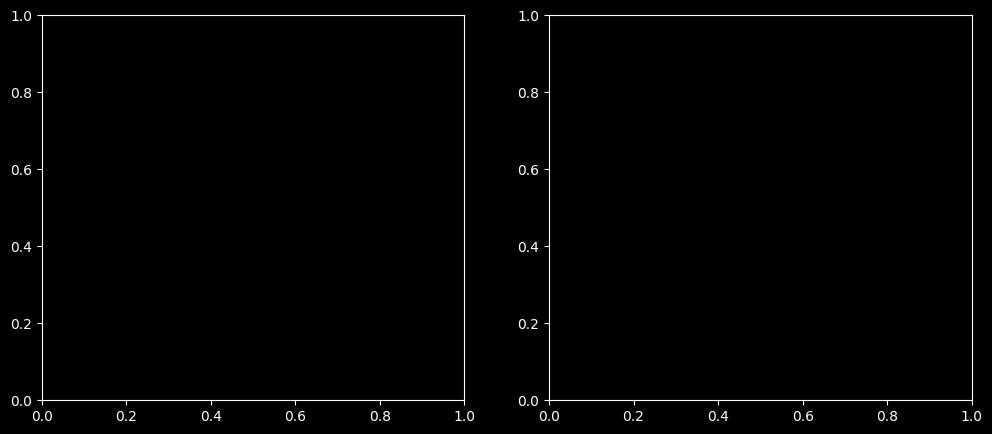

In [1]:
# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials if trial.value is not None]
trial_nums_valid = [trial.number for trial in study.trials if trial.value is not None]

ax1.plot(trial_nums_valid, trial_values, "b-", alpha=0.7)
ax1.axhline(
    y=max(trial_values),  # Best is now maximum F1
    color="r",
    linestyle="--",
    alpha=0.7,
    label=f"Best: {max(trial_values):.4f}",
)
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Validation Macro F1")
ax1.set_title("Optimization History")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter importance (if enough trials)
importance = optuna.importance.get_param_importances(study)
params = list(importance.keys())
values = list(importance.values())

ax2.barh(params, values)
ax2.set_xlabel("Importance")
ax2.set_title("Hyperparameter Importance")
ax2.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()

# Show best trial details
print("Best Trial Details:")
print(f"Trial number: {study.best_trial.number}")
print(f"Validation macro F1: {study.best_trial.value:.4f}")
print("Parameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

In [9]:
## Save Final Results and Create Experiment Summary
# Save final optimization results
final_results = {
    "experiment_name": EXPERIMENT_NAME,
    "optimization_completed": datetime.now().isoformat(),
    "total_trials": len(study.trials),
    "best_trial_number": study.best_trial.number,
    "best_val_f1": study.best_value,
    "best_params": study.best_params,
    "study_statistics": {
        "n_complete": len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]),
        "n_failed": len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]),
        "n_pruned": len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]),
    }
}

with open(os.path.join(LOG_DIR, "final_results.json"), "w") as f:
    json.dump(final_results, f, indent=2)

In [10]:
best_trial = study.best_trial
best_results = {
    "model_xgb": best_trial.user_attrs["model_xgb"],
    "model_dim": best_trial.user_attrs["model_dim"],
    "f1_discrepancy": best_trial.user_attrs["f1_discrepancy"],
    "val_f1": best_trial.value,
}
best_hp = best_trial.user_attrs["hyperparameters"]

print(f"Best model validation macro F1: {best_results['val_f1']:.4f}")
print(f"F1 Score Discrepancy: {best_results['f1_discrepancy']:.4f}")
print("Parameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best model validation macro F1: 0.6951
F1 Score Discrepancy: 0.2801
Parameters:
  dim_n_components: 600
  xgb_max_depth: 5
  xgb_learning_rate: 0.00556178353250608
  xgb_subsample: 0.5635517015265841
  xgb_colsample_bynode: 0.29465651555894085
  xgb_min_child_weight: 15.509993186959967
  xgb_min_split_loss: 1.457161565140586
  xgb_lambda: 8.047558328691794
  xgb_alpha: 6.920562038774711


In [11]:
trials_df = study.trials_dataframe()
with open(os.path.join(LOG_DIR, "trial_results.csv"), "w") as f:
    trials_df.to_csv(f, index=False)

# TODO: Sample the best hyperparameters from the top N trials, in case theres multiple
# possible peaks, or if the best trial is a freak anomaly.

In [21]:
with open(os.path.join(LOG_DIR, "best_hp.pkl"), "wb") as f:
    pickle.dump(best_hp, f)

In [8]:
with open("logs/optuna_exp_20250810_213811/best_hp.pkl", "rb") as f:
    loaded_best_hp = pickle.load(f)

## Inference with Optimized Model
Using the best hyperparameters found by Optuna optimization.

In [9]:
pred_y = inference(
    test_X, model_xgb=best_results["model_xgb"], model_dim=best_results["model_dim"]
)

NameError: name 'best_results' is not defined

In [ ]:
pred_df = pd.DataFrame(
    # zip(test_tfidf_df.index, np.where(pred_y > 0.5, 1, 0)), columns=["row ID", "label"]
    zip(test_tfidf_df.index, np.where(pred_y > 0.5, 1, 0)), columns=["id", "label"]
)
# YYYYMMDD-HHMM-optuna.csv
pred_df.to_csv(f"{datetime.now().strftime('%Y%m%d-%H%M')}-optuna.csv", index=False)

## Stratified Cross-Validation with Model Ensembling
Using the best hyperparameters found by Optuna, we'll now train multiple models using stratified cross-validation and ensemble their predictions for better performance and robustness.

In [10]:
def train_cv_ensemble(hp, X, y, test_X, n_splits=5, random_state=42):
    """
    Train multiple models using stratified cross-validation and ensemble their predictions.
    
    Args:
        hp: Hyperparameters object
        X: Training features
        y: Training labels
        test_X: Test features for prediction
        n_splits: Number of CV folds
        random_state: Random state for reproducibility
    
    Returns:
        dict: Contains ensemble predictions, individual model predictions, and CV scores
    """
    # Set up stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Storage for models and predictions
    cv_models = []
    cv_scores = []
    oof_predictions = np.zeros(len(X))  # Out-of-fold predictions
    test_predictions = np.zeros((len(test_X), n_splits))  # Test predictions from each fold
    
    print(f"Training {n_splits} models using stratified cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split data for this fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Train model for this fold
        results = train(
            hp, 
            train_X=X_train_fold, 
            train_y=y_train_fold, 
            val_X=X_val_fold, 
            val_y=y_val_fold, 
            quiet=True
        )
        
        # Store model and validation score
        cv_models.append({
            'model_xgb': results['model_xgb'],
            'model_dim': results['model_dim']
        })
        cv_scores.append(results['val_f1'])
        
        # Generate out-of-fold predictions
        val_pred = inference(
            X_val_fold, 
            model_xgb=results['model_xgb'], 
            model_dim=results['model_dim']
        )
        oof_predictions[val_idx] = val_pred
        
        # Generate test predictions for this fold
        test_pred = inference(
            test_X, 
            model_xgb=results['model_xgb'], 
            model_dim=results['model_dim']
        )
        test_predictions[:, fold] = test_pred
        
        print(f"Fold {fold + 1} validation F1: {results['val_f1']:.4f}")
    
    # Calculate overall CV score
    oof_f1 = f1_score(y, (oof_predictions > 0.5).astype(int), average='macro')
    
    # Ensemble test predictions (simple averaging)
    ensemble_test_pred = np.mean(test_predictions, axis=1)
    
    print(f"\nCross-validation results:")
    print(f"Individual fold F1 scores: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"Mean CV F1: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"Out-of-fold F1: {oof_f1:.4f}")
    
    return {
        'cv_models': cv_models,
        'cv_scores': cv_scores,
        'mean_cv_score': np.mean(cv_scores),
        'std_cv_score': np.std(cv_scores),
        'oof_predictions': oof_predictions,
        'oof_f1': oof_f1,
        'test_predictions': test_predictions,
        'ensemble_test_pred': ensemble_test_pred
    }

In [11]:
# Combine train and validation sets for cross-validation
full_train_X = np.vstack([train_X, val_X])
full_train_y = np.hstack([train_y, val_y])

print(f"Training ensemble with optimal hyperparameters:")
print(f"Full training set size: {len(full_train_X)}")
print(f"Test set size: {len(test_X)}")

# Train ensemble using cross-validation
ensemble_results = train_cv_ensemble(
    hp=loaded_best_hp,
    X=full_train_X,
    y=full_train_y,
    test_X=test_X,
    n_splits=3,
    random_state=HP.seed,
)

Training ensemble with optimal hyperparameters:
Full training set size: 17184
Test set size: 4296
Training 3 models using stratified cross-validation...
Training fold 1/3
Fold 1 validation F1: 0.7226
Training fold 2/3
Fold 1 validation F1: 0.7226
Training fold 2/3
Fold 2 validation F1: 0.7227
Training fold 3/3
Fold 2 validation F1: 0.7227
Training fold 3/3
Fold 3 validation F1: 0.7269

Cross-validation results:
Individual fold F1 scores: ['0.7226', '0.7227', '0.7269']
Mean CV F1: 0.7241 ± 0.0020
Out-of-fold F1: 0.7241
Fold 3 validation F1: 0.7269

Cross-validation results:
Individual fold F1 scores: ['0.7226', '0.7227', '0.7269']
Mean CV F1: 0.7241 ± 0.0020
Out-of-fold F1: 0.7241


In [ ]:
# Visualize ensemble results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cross-validation scores
axes[0, 0].bar(range(1, len(ensemble_results['cv_scores']) + 1), ensemble_results['cv_scores'])
axes[0, 0].axhline(y=ensemble_results['mean_cv_score'], color='r', linestyle='--', 
                   label=f"Mean: {ensemble_results['mean_cv_score']:.4f}")
axes[0, 0].axhline(y=ensemble_results['oof_f1'], color='g', linestyle='--', 
                   label=f"OOF: {ensemble_results['oof_f1']:.4f}")
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('Cross-Validation F1 Scores')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Prediction distribution for each fold
test_preds = ensemble_results['test_predictions']
for i in range(test_preds.shape[1]):
    axes[0, 1].hist(test_preds[:, i], alpha=0.6, bins=30, label=f'Fold {i+1}')
axes[0, 1].hist(ensemble_results['ensemble_test_pred'], alpha=0.8, bins=30, 
                color='black', label='Ensemble', linewidth=2)
axes[0, 1].set_xlabel('Prediction Probability')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Test Prediction Distributions')
axes[0, 1].legend()

# 3. Ensemble vs individual predictions scatter
ensemble_pred = ensemble_results['ensemble_test_pred']
individual_pred = test_preds[:, 0]  # First fold as example
axes[1, 0].scatter(individual_pred, ensemble_pred, alpha=0.6)
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='y=x')
axes[1, 0].set_xlabel('Individual Model Prediction (Fold 1)')
axes[1, 0].set_ylabel('Ensemble Prediction')
axes[1, 0].set_title('Ensemble vs Individual Predictions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction variance across folds
prediction_std = np.std(test_preds, axis=1)
axes[1, 1].hist(prediction_std, bins=30, alpha=0.7)
axes[1, 1].set_xlabel('Standard Deviation of Predictions')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Prediction Uncertainty Across Folds')
axes[1, 1].axvline(x=np.mean(prediction_std), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(prediction_std):.4f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nEnsemble Performance Summary:")
print(f"============================")
print(f"Single model validation F1 (best trial): {best_results['val_f1']:.4f}")
print(f"Ensemble mean CV F1: {ensemble_results['mean_cv_score']:.4f} ± {ensemble_results['std_cv_score']:.4f}")
print(f"Ensemble out-of-fold F1: {ensemble_results['oof_f1']:.4f}")
print(f"")
print(f"Prediction Statistics:")
print(f"Mean prediction uncertainty (std): {np.mean(prediction_std):.4f}")
print(f"Max prediction uncertainty: {np.max(prediction_std):.4f}")
print(f"Min prediction uncertainty: {np.min(prediction_std):.4f}")

# Compare single model vs ensemble predictions
single_model_pred = inference(test_X, model_xgb=best_results["model_xgb"], model_dim=best_results["model_dim"])
ensemble_pred = ensemble_results['ensemble_test_pred']

print(f"\nPrediction Comparison:")
print(f"Single model mean prediction: {np.mean(single_model_pred):.4f}")
print(f"Ensemble mean prediction: {np.mean(ensemble_pred):.4f}")
print(f"Correlation between single and ensemble: {np.corrcoef(single_model_pred, ensemble_pred)[0,1]:.4f}")

# Count prediction differences
binary_single = (single_model_pred > 0.5).astype(int)
binary_ensemble = (ensemble_pred > 0.5).astype(int)
diff_count = np.sum(binary_single != binary_ensemble)
print(f"Number of different binary predictions: {diff_count} out of {len(binary_single)} ({diff_count/len(binary_single)*100:.2f}%)")

In [19]:
# Save ensemble predictions
ensemble_pred_df = pd.DataFrame({
    'id': test_tfidf_df.index,
    'label': np.where(ensemble_results['ensemble_test_pred'] > 0.5, 1, 0)
})

# Save with ensemble identifier
ensemble_filename = f"{datetime.now().strftime('%Y%m%d-%H%M')}-ensemble-cv.csv"
ensemble_pred_df.to_csv(ensemble_filename, index=False)
print(f"Ensemble predictions saved to: {ensemble_filename}")

# Save ensemble models and results
ensemble_data = {
    "hyperparameters": asdict(loaded_best_hp),
    "cv_results": ensemble_results,
    "experiment_name": EXPERIMENT_NAME,
    "ensemble_filename": ensemble_filename,
    "ensemble_performance": {
        "mean_cv_f1": ensemble_results["mean_cv_score"],
        "std_cv_f1": ensemble_results["std_cv_score"],
        "oof_f1": ensemble_results["oof_f1"],
    },
}

# Save ensemble metadata
ensemble_metadata_file = os.path.join(LOG_DIR, "ensemble_metadata.json")
with open(ensemble_metadata_file, "w") as f:
    # Convert numpy types to native Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.float64):
            return float(obj)
        elif isinstance(obj, np.int64):
            return int(obj)
        return obj
    
    # Create a JSON-serializable version
    json_data = {}
    for key, value in ensemble_data.items():
        if key == 'cv_results':
            # Save only the essential metrics, not the models
            json_data[key] = {
                'cv_scores': [float(x) for x in value['cv_scores']],
                'mean_cv_score': float(value['mean_cv_score']),
                'std_cv_score': float(value['std_cv_score']),
                'oof_f1': float(value['oof_f1'])
            }
        else:
            json_data[key] = value
    
    json.dump(json_data, f, indent=2)

print(f"Ensemble metadata saved to: {ensemble_metadata_file}")

# Optionally save individual models (warning: large file size)
save_models = False  # Set to True if you want to save all models
if save_models:
    models_file = os.path.join(LOG_DIR, "ensemble_models.pkl")
    with open(models_file, "wb") as f:
        pickle.dump(ensemble_results['cv_models'], f)
    print(f"Ensemble models saved to: {models_file}")

print(f"\nFinal Ensemble Summary:")
print(f"======================")
print(f"Submission file: {ensemble_filename}")
print(f"Ensemble CV F1: {ensemble_results['mean_cv_score']:.4f} ± {ensemble_results['std_cv_score']:.4f}")
print(f"Out-of-fold F1: {ensemble_results['oof_f1']:.4f}")
print(f"Number of models: {len(ensemble_results['cv_models'])}")
print(f"Prediction uncertainty (mean std): {np.mean(np.std(ensemble_results['test_predictions'], axis=1)):.4f}")

Ensemble predictions saved to: 20250810-2311-ensemble-cv.csv
Ensemble metadata saved to: ./logs/optuna_exp_20250810_225430/ensemble_metadata.json

Final Ensemble Summary:
Submission file: 20250810-2311-ensemble-cv.csv
Ensemble CV F1: 0.7202 ± 0.0045
Out-of-fold F1: 0.7202
Number of models: 2
Prediction uncertainty (mean std): 0.0516


In [ ]:
# Run the LogisticRegression + Optuna hyperparameter optimization
# This will be more efficient than XGBoost and optimize the entire pipeline

# Note: Uncomment the line below to run the optimization
# %run task3/logistic_optuna.py

print("LogisticRegression + Optuna optimization script created!")
print("The script optimizes:")
print("  1. TfidfVectorizer hyperparameters (max_features, min_df, max_df, ngram_range, etc.)")
print("  2. SelectKBest feature selection (k value)")
print("  3. LogisticRegression hyperparameters (C, penalty, solver, etc.)")
print()
print("Key optimizations:")
print("  - Text cleaning is done once to save time")
print("  - Uses 5-fold stratified cross-validation")
print("  - Optimizes for macro F1 score")
print("  - Handles solver/penalty compatibility automatically")
print("  - Saves all results, models, and submission files")
print()
print("To run: uncomment the %run line above or execute 'python task3/logistic_optuna.py' in terminal")